### Neccessary imports

In [3]:
import (
	"fmt"
	"image/color"
	"math"
	"bytes"
	"math/rand"

	"gonum.org/v1/gonum/mat"
	"gonum.org/v1/plot"
	"gonum.org/v1/plot/plotter"
	"gonum.org/v1/plot/vg"
)

### Helper functions

In [8]:
// Print a matrix in a nice format
func print_matrix(matrix *mat.Dense) {
	var rows, columns = matrix.Dims()
	fmt.Println("Matrix (", rows, "x", columns, "): ")
	for i := 0; i < rows; i++ {
		for j := 0; j < columns; j++ {
			fmt.Printf("%f ", matrix.At(i, j))
		}
		fmt.Println("")
	}
	fmt.Println("")
}

// Print a vector in a nice format
func print_vector(vector *mat.VecDense) {
	var rows, cols = vector.Dims()
	fmt.Println("Matrix (", rows, "x", cols, "): ")
	for i := 0; i < rows; i++ {
		fmt.Printf("%f ", vector.At(i, 0))
	}
	fmt.Println("")
}


// Function to plot the graphs of a list of functions given the x and y min and max
func plot_functions(x_min float64, x_max float64, y_min float64, y_max float64, functions []func(float64) float64, x_points [][]float64, y_points [][]float64) *plot.Plot {
	// Create a plot and set its title and axis label
	p, err := plot.New()
	if err != nil {
		panic(err)
	}
	p.Title.Text = "Graphs"
	p.X.Label.Text = "X"
	p.Y.Label.Text = "Y"
	p.X.Min = x_min
	p.X.Max = x_max
	p.Y.Min = y_min
	p.Y.Max = y_max

	// Create a grid
	grid := plotter.NewGrid()
	p.Add(grid)

	// Create a line of points
	for i := 0; i < len(functions); i++ {
		pts := make(plotter.XYs, 100)
		for j := 0; j < 100; j++ {
			x := x_min + (x_max-x_min)*float64(j)/100
			pts[j].X = x
			pts[j].Y = math.Min(functions[i](x), y_max)
		}

		// Add the line to the plot
		l, err := plotter.NewLine(pts)
		if err != nil {
			panic(err)
		}
		l.LineStyle.Width = vg.Points(1)
		l.LineStyle.Color = color.RGBA{R: uint8(rand.Intn(255)), G: uint8(rand.Intn(255)), B: uint8(rand.Intn(255)), A: 255}
		p.Add(l)
	}

	// Create a scatter plot
	for i := 0; i < len(x_points); i++ {
		pts := make(plotter.XYs, len(x_points[i]))
		for j := 0; j < len(x_points[i]); j++ {
			pts[j].X = x_points[i][j]
			pts[j].Y = y_points[i][j]
		}

		// Add the line to the plot
		s, err := plotter.NewScatter(pts)
		if err != nil {
			panic(err)
		}
		s.GlyphStyle.Color = color.RGBA{R: uint8(rand.Intn(255)), G: uint8(rand.Intn(255)), B: uint8(rand.Intn(255)), A: 255}
		p.Add(s)
	}

	return p
}


// Display a plot in the notebook
func display_plot(p *plot.Plot) {
	var buf bytes.Buffer
	c, err := p.WriterTo(6*vg.Inch, 6*vg.Inch, "png")
	if err != nil {
			panic(err)
	}
	if _, err := c.WriteTo(&buf); err != nil {
			panic(err)
	}
	Display(display.PNG(buf.Bytes()))
}

// Calculate the rmse for a regression of a function given a list of x and y points and the function
func rmse(x_points []float64, y_points []float64, function func(float64) float64) float64 {
	var sum float64 = 0
	for i := 0; i < len(x_points); i++ {
		sum += math.Pow(y_points[i]-function(x_points[i]), 2)
	}
	return math.Sqrt(sum / float64(len(x_points)))
}

### Least squares method

$\vec{x} = (A^{T}A)^{-1}A^{T}\vec{b}$

In [5]:
// Solve a linear system of equations using least squares
// returns a list of the calculated constants ordered by the columns of A
func least_square(A *mat.Dense, b *mat.Dense) []float64 {
	A_rows, A_cols := A.Dims()
	_, b_cols := b.Dims()

	// Create the matrix (A^T*A)^-1
	A_T_A := mat.NewDense(A_cols, A_cols, nil)
	A_T_A.Mul(A.T(), A)
	A_T_A_inv := mat.NewDense(A_cols, A_cols, nil)
	A_T_A_inv.Inverse(A_T_A)

	// Create the matrix A^T*b
	A_T_b := mat.NewDense(A_cols, b_cols, nil)
	A_T_b.Mul(A.T(), b)

	// Calculate the solution x
	x := mat.NewDense(A_cols, b_cols, nil)
	x.Mul(A_T_A_inv, A_T_b)

	x_list := make([]float64, A_cols)
	for i := 0; i < A_cols; i++ {
		x_list[i] = x.At(i, 0)
	}

	return x_list
}

### Polynomial interpolation

In [6]:
// Perform polynomial interpolation to find the coefficients of the polynomial
func polynomial_interpolation(x []float64, y []float64) []float64 {
	point_count := len(x)
	y_vector := mat.NewVecDense(point_count, y)
	
	// Create vander matrix
	vander_matrix := mat.NewDense(point_count, point_count, nil)
	for row := 0; row < point_count; row++ {
		for col := 0; col < point_count; col++ {
			vander_matrix.Set(row, col, math.Pow(x[row], float64(col)))
		}
	}

	// Solve the system of equations
	var c mat.VecDense
	c.SolveVec(vander_matrix, y_vector)

	// Convert the solution to a list
	solution := make([]float64, point_count)
	for i := 0; i < point_count; i++ {
		solution[i] = c.At(i, 0)
	}
	return solution
}

## Problem 2

Least squares solution:  [1.0708944034566272 0.061849368625103374] MSE:  0.13346578073852655
Polynomial interpolation solution:  [0 -8.78166723647708 44.165113675259256 -70.92037448567002 51.97907708140844 -17.549630642626468 2.197481608106086] MSE:  2.0158593113977334e-13


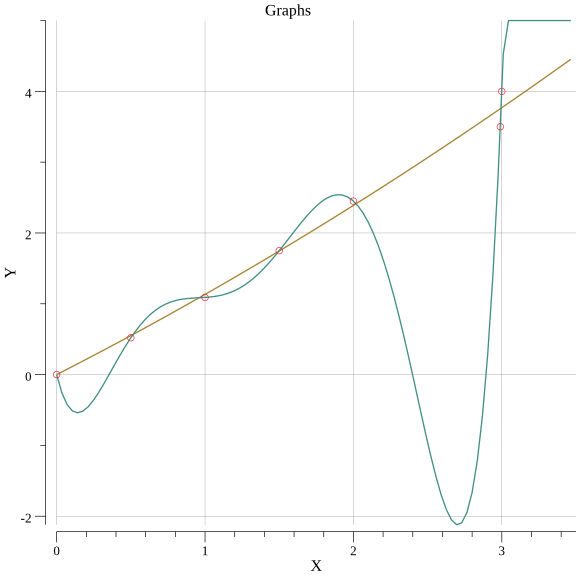

In [10]:
// Data points
x := []float64{0.0, 0.5, 1.0, 1.5, 2.0, 2.99, 3.0}
y := []float64{0.0, 0.52, 1.09, 1.75, 2.45, 3.5, 4.0}

// Solve using least squares
A := mat.NewDense(7, 2, nil)
for i := 0; i < 7; i++ {
	A.Set(i, 0, x[i])
	A.Set(i, 1, math.Pow(x[i], 2))
}
b := mat.NewDense(7, 1, y)

c1 := least_square(A, b)
func f1(x float64) float64 {return c1[0]*x + c1[1]*math.Pow(x, 2)};
e1 := rmse(x, y, f1)
fmt.Println("Least squares solution: ", c1, "MSE: ", e1)

// Solve using polynomial interpolation
c2 := polynomial_interpolation(x, y)
func f2(x float64) float64 {var y float64; for i := 0; i < len(c2); i++ {y = y + c2[i]*math.Pow(x, float64(i))}; return y};
e2 := rmse(x, y, f2)
fmt.Println("Polynomial interpolation solution: ", c2, "MSE: ", e2)

// Plot the results
p := plot_functions(0, 3.5, 0, 5, []func(float64) float64{f1, f2}, [][]float64{x}, [][]float64{y})
display_plot(p)